In [1]:
#import necessary library
import pandas as pd
import numpy as np
import os

I will use here some hotel reviews data. Each observation consists in one customer review for one hotel. Each customer review is composed of a textual feedback of the customer's experience at the hotel and an overall rating. The data can be found here: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

For each textual reviewIwe want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 2.5/10 to 10/10. In order to simplify the problem we will split those into two categories:

bad reviews have overall ratings < 5
good reviews have overall ratings >= 5
The challenge here is to be able to predict this information using only the raw textual data from the review. Let's get it started!

In [20]:
#read the already downloaded data
df = pd.read_csv(r"F:\onedrive\OneDrive - University of Central Florida\Data Mining I\Data\Hotel_Reviews.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [21]:
#Since every since review could have both positive and negative parts. I will append both of together as review
df["text"] = df["Negative_Review"] + df["Positive_Review"]
df['label'] = df['Reviewer_Score'].apply(lambda x: 1 if x>=5 else 0)
df = df[['text', 'label']]
df.head()

,text,label
0,I am so angry that i made this post available...,0
1,No Negative No real complaints the hotel was g...,1
2,Rooms are nice but for elderly a bit difficul...,1
3,My room was dirty and I was afraid to walk ba...,0
4,You When I booked with your company on line y...,1


In [ ]:
from openai import OpenAI
client = OpenAI(api_key="Your API key")
def classify_sentiment(text):
    response = list(client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Analyze the sentiment of the text and rate the sentiment from -1 to 1, 1 is super positive, -1 is super negative, 0 is neutral."},
            {"role": "user", "content": text}
        ]
    ).choices)[0].message.content
    return response

In [ ]:
# Apply the classification function to each entry in the DataFrame
df['sentiment'] = ''
for j in range(df.shape[0]):
    if df.loc[j,'sentiment'] == '':
        try:
            df.loc[j,'sentiment'] = classify_sentiment(df.loc[j,'text'])
            df.to_csv('review_with_sentiment_updated.csv')
        except Exception as e:
            continue

In [3]:
#import the saved data
import pandas as pd
data = pd.read_csv(r'review_with_sentiment_updated.csv')
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88463 entries, 8 to 98501
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  88463 non-null  int64 
 1   text        88463 non-null  object
 2   label       88463 non-null  int64 
 3   sentiment   88463 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.4+ MB


C:\Users\mo314794\AppData\Local\Temp\ipykernel_15296\2069459310.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'review_with_sentiment_updated.csv')


In [12]:
data.loc[data['sentiment'] != '','sentiment']

8        The sentiment of the text is negative due to c...
28       The sentiment of the text is mixed. While it m...
47       The sentiment of the text is generally positiv...
66       The sentiment of the text is mixed. While ther...
86       The sentiment of the text is mostly mixed. Whi...
                               ...                        
98497    The sentiment of the text is very positive. Th...
98498    The sentiment of the text is primarily negativ...
98499    The sentiment of the text is generally positiv...
98500    The sentiment of the text is mostly positive, ...
98501    The sentiment of the text is very positive. Th...
Name: sentiment, Length: 88463, dtype: object

In [18]:
#drop previous index column
data =data.drop('Unnamed: 0', axis=1)

In [23]:
#see the original and predicted sentiment
data.head()
data.reset_index(inplace = True)
print(data.loc[0,'sentiment'])
print(data.loc[0,'text'])

The sentiment of the text is negative due to complaints about the cleanliness of the room and a delay in check-in time. Therefore, I would rate the sentiment as -0.8.
 Even though the pictures show very clean rooms the actual room was quit dirty and outlived Also check in is at 15 o clock but our room was not ready at that timeNo Positive


In [24]:
#extract only values from the entire text
import numpy as np
data['extracted_sentiment'] = data['sentiment'].str.findall(r'[-+]?\d*\.\d+|\d+')
# Function to filter numbers within the range of -1 to 1
def filter_numbers(matches):
    filtered = [float(num) for num in matches if -1 <= float(num) <= 1]
    return np.median(filtered)

data['extracted_sentiment'] = data['extracted_sentiment'].apply(filter_numbers)

F:\Anaconda\envs\learning\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
F:\Anaconda\envs\learning\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
data.loc[data['sentiment'] != '','extracted_sentiment']

0       -0.8
1        0.5
2        0.5
3        0.2
4        0.2
        ... 
88458    1.0
88459   -0.5
88460    0.7
88461    0.6
88462    1.0
Name: extracted_sentiment, Length: 88463, dtype: float64

<Axes: >

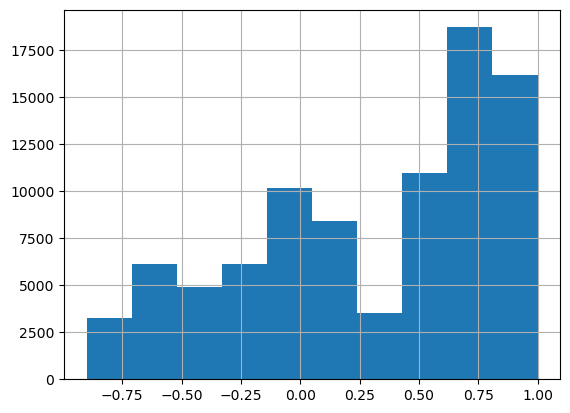

In [27]:
data['extracted_sentiment'].hist()

<Axes: title={'center': 'extracted_sentiment'}, xlabel='label'>

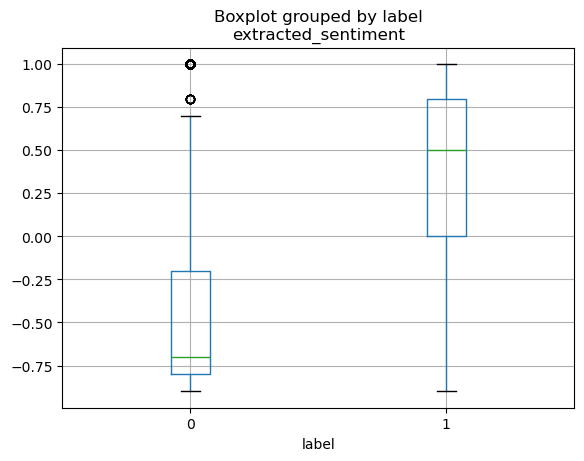

In [28]:
data[['label','extracted_sentiment']]
data.boxplot(
    column = 'extracted_sentiment',
    by = 'label'
)
plt.show(

In [30]:
pd.crosstab(
    index = data['label'],
    columns = np.sign(data['extracted_sentiment'])
)

extracted_sentiment,-1.0,0.0,1.0
label,,,
0,2940,237,691
1,17555,9894,57135


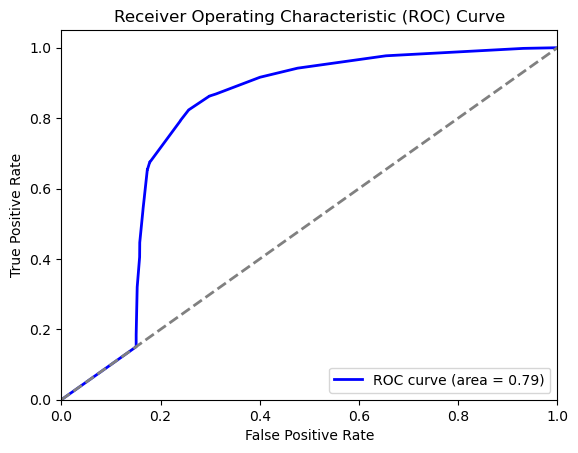

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(
    y_true = data.loc[~data['extracted_sentiment'].isna(),'label'],
    y_score = data.loc[~data['extracted_sentiment'].isna(),'extracted_sentiment']
)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()